In [1]:
print("all ok")

all ok


In [2]:
from transformers import AutoModelForCausalLM, AutoTokenizer
from PIL import Image

/home/ai/Desktop/ocr_auto_labelling_QWEN/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
!pip install transformers accelerate torch torchvision pillow
!pip install qwen-vl-utils


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.7/39.7 MB 31.2 MB/s eta 0:00:00 MB/s eta 0:00:01:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [qwen-vl-utils]

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


In [5]:
from transformers import Qwen2_5_VLForConditionalGeneration, AutoTokenizer, AutoProcessor
from qwen_vl_utils import process_vision_info

In [6]:
model = Qwen2_5_VLForConditionalGeneration.from_pretrained(
    "Qwen/Qwen2.5-VL-7B-Instruct", torch_dtype="auto", device_map="auto"
)

Loading checkpoint shards: 100%|██████████| 5/5 [00:08<00:00,  1.68s/it]


In [7]:
# default processer
processor = AutoProcessor.from_pretrained("Qwen/Qwen2.5-VL-7B-Instruct")

The image processor of type `Qwen2VLImageProcessor` is now loaded as a fast processor by default, even if the model checkpoint was saved with a slow processor. This is a breaking change and may produce slightly different outputs. To continue using the slow processor, instantiate this class with `use_fast=False`. Note that this behavior will be extended to all models in a future release.
You have video processor config saved in `preprocessor.json` file which is deprecated. Video processor configs should be saved in their own `video_preprocessor.json` file. You can rename the file or load and save the processor back which renames it automatically. Loading from `preprocessor.json` will be removed in v5.0.


In [9]:
image = Image.open("./clean_data/clean_data/nitish0.png")

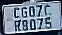

In [10]:
image

In [16]:
messages = [
    {
        "role": "user",
        "content": [
            {
                "type": "image",
                "image": image,  # Use the loaded image object here
            },
            {"type": "text", "text": "What is the text in the given indian numplate image ?"},
        ],
    }
]


In [22]:
# Modify the prompt to ask specifically for the license plate number
messages = [
    {
        "role": "user",
        "content": [
            {
                "type": "image",
                "image": image,
            },
            {"type": "text", "text": "What is the license plate number in this image? Provide only the number."},
        ],
    }
]

In [23]:
text = processor.apply_chat_template(
    messages, tokenize=False, add_generation_prompt=True
)

In [24]:
image_inputs, video_inputs = process_vision_info(messages)


In [25]:
inputs = processor(
    text=[text],
    images=image_inputs,
    videos=video_inputs,
    padding=True,
    return_tensors="pt",
)

In [26]:
inputs = inputs.to("cuda")

# Inference: Generation of the output
generated_ids = model.generate(**inputs, max_new_tokens=128)
generated_ids_trimmed = [
    out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
]

In [27]:
output_text = processor.batch_decode(
    generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
)
print(output_text)

['CG07CRB075']


In [29]:
import os
import csv
from PIL import Image

input_dir = "./bad_folder/bad_folder/"
output_csv = "qwen_bad_license_plate_results.csv"

image_files = [f for f in os.listdir(input_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]

with open(output_csv, 'w', newline='') as outfile:
    writer = csv.writer(outfile)
    writer.writerow(['Filename', 'License Plate'])  # Write header

    for filename in image_files:
        image_path = os.path.join(input_dir, filename)
        try:
            image = Image.open(image_path)

            # Modify the prompt to ask specifically for the license plate number
            messages = [
                {
                    "role": "user",
                    "content": [
                        {
                            "type": "image",
                            "image": image,
                        },
                        {"type": "text", "text": "What is the license plate number in this image? Provide only the number."},
                    ],
                }
            ]

            text = processor.apply_chat_template(
                messages, tokenize=False, add_generation_prompt=True
            )
            image_inputs, video_inputs = process_vision_info(messages)
            inputs = processor(
                text=[text],
                images=image_inputs,
                videos=video_inputs,
                padding=True,
                return_tensors="pt",
            )
            inputs = inputs.to("cuda")

            generated_ids = model.generate(**inputs, max_new_tokens=128)
            generated_ids_trimmed = [
                out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
            ]
            license_plate = processor.batch_decode(
                generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
            )[0].strip() # Get the first generated text and remove leading/trailing whitespace

            # Clean up the extracted text if it contains unnecessary characters like quotes or brackets
            license_plate = license_plate.replace("\"", "").replace("'", "").replace("[", "").replace("]", "")


            writer.writerow([filename, license_plate])
            print(f"Processed {filename}: {license_plate}")

        except Exception as e:
            print(f"Error processing {filename}: {e}. Skipping.")

print(f"Processing complete. Results saved to {output_csv}")

Processed nitish454.png: 7102457
Processed nitish197.png: CJ-7CV-6572
Processed nitish29.png: LC-07EC-901
Processed nitish42.png: 7451063
Processed nitish5.png: 18
Processed nitish372.png: CG 07 AV 635
Processed nitish208.png: 1011
Processed nitish337.png: DC-0728
Processed nitish219.png: DP-AY-8977
Processed nitish212.png: 7410
Processed nitish430.png: LCC07BUDE49
Processed nitish246.png: CG 04 B 8666
Processed nitish386.png: CJ7
Processed nitish317.png: C0117403
Processed nitish556.png: LG-8ACP-579
Processed nitish247.png: CJ 2461P
Processed nitish157.png: 7015
Processed nitish496.png: JH-00N-9657
Processed nitish431.png: 07CM360G
Processed nitish442.png: 01-078E-8225
Processed nitish77.png: 789456
Processed nitish254.png: CO-021X-5810
Processed nitish109.png: 0914717
Processed nitish202.png: 07-18774
Processed nitish168.png: 7654321
Processed nitish240.png: CCH71H
Processed nitish89.png: 0G047LP501
Processed nitish537.png: CGD7CU378
Processed nitish295.png: CC 072E 0257
Processed ni

In [ ]:
import os
import csv
from PIL import Image

input_dir = "./clean_data/clean_data/"
output_csv = "qwen_license_plate_results.csv"

image_files = [f for f in os.listdir(input_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]

with open(output_csv, 'w', newline='') as outfile:
    writer = csv.writer(outfile)
    writer.writerow(['Filename', 'License Plate'])  # Write header

    for filename in image_files:
        image_path = os.path.join(input_dir, filename)
        try:
            image = Image.open(image_path)

            # Modify the prompt to ask specifically for the license plate number
            messages = [
                {
                    "role": "user",
                    "content": [
                        {
                            "type": "image",
                            "image": image,
                        },
                        {"type": "text", "text": "What is the license plate number in this image? Provide only the number."},
                    ],
                }
            ]

            text = processor.apply_chat_template(
                messages, tokenize=False, add_generation_prompt=True
            )
            image_inputs, video_inputs = process_vision_info(messages)
            inputs = processor(
                text=[text],
                images=image_inputs,
                videos=video_inputs,
                padding=True,
                return_tensors="pt",
            )
            inputs = inputs.to("cuda")

            generated_ids = model.generate(**inputs, max_new_tokens=128)
            generated_ids_trimmed = [
                out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
            ]
            license_plate = processor.batch_decode(
                generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
            )[0].strip() # Get the first generated text and remove leading/trailing whitespace

            # Clean up the extracted text if it contains unnecessary characters like quotes or brackets
            license_plate = license_plate.replace("\"", "").replace("'", "").replace("[", "").replace("]", "")


            writer.writerow([filename, license_plate])
            print(f"Processed {filename}: {license_plate}")

        except Exception as e:
            print(f"Error processing {filename}: {e}. Skipping.")

print(f"Processing complete. Results saved to {output_csv}")